In [2]:
# Import and Load Config

import sys
sys.path.append(".")

import torch 

from omegaconf import OmegaConf

from dmm.util import instantiate_from_config


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    # model.cpu()
    model.eval()
    return model

# Download the ckpt file at: https://alteredstatemachine-my.sharepoint.com/:u:/g/personal/michael_hu_alteredstatemachine_xyz/Ed2DNniBrs9JnEhS-p9PvqUB3_nPO0ewXJq3exPzOMKZlw?e=fVwnQ8

def get_model():
    config = OmegaConf.load("configs/uncon_.yaml")  
    model = load_model_from_config(config, "last.ckpt")
    return model

In [3]:
# Load Model and Sampler

from dmm.models.diffusion.ddim import DDIMSampler

model = get_model()
sampler = DDIMSampler(model) # TODO: Modify this for the uncond model

Loading model from /home/hu/audio-diffusion/logs/2022-12-07T20-31-12_uncon_/checkpoints/last.ckpt


/home/hu/miniconda3/envs/th/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v1.10.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


DDPM: Running in eps-prediction mode
DiffusionWrapper has 459.71 M params.
Keeping EMAs of 458.


A classical sampling methods:

In [21]:
# Local RTX3070 Need around 3 mins to generate 1 sample

a = model.sample(batch_size=1)

Sampling t: 100%|██████████| 1000/1000 [23:59<00:00,  1.44s/it]


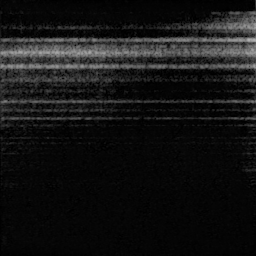

In [22]:
# Plot the sample

images = (a / 2 + 0.5).clamp(0, 1)
images = (images.cpu().permute(0,2,3,1).numpy() * 255).round().astype("uint8")
images = list(
    map(lambda _: Image.fromarray(_[:, :, 0]), images)
    if images.shape[3] == 1
    else map(lambda _: Image.fromarray(_, mode="RGB").convert("L"), images)
)
display(images[0])

In [4]:
# Image to Audio Function
import librosa
from librosa.beat import beat_track
from IPython.display import Audio
import numpy as np

from PIL import Image 

def image_to_audio(image: Image.Image) -> np.ndarray:
    """Converts spectrogram to audio.

    Args:
        image (np.ndarray): x_res x y_res grayscale image

    Returns:
        audio (np.ndarray): raw audio
    """
    bytedata = np.frombuffer(image.tobytes(), dtype="uint8").reshape((image.height, image.width))
    log_S = bytedata.astype("float") * 80 / 255 - 80 # top_db: 80
    S = librosa.db_to_power(log_S)
    audio = librosa.feature.inverse.mel_to_audio(
        S, sr=22050, n_fft=2048, hop_length=512, n_iter=32
    )
    return audio


def loop_it(audio: np.ndarray,
            sample_rate: int = 22050,
            loops: int = 10) -> np.ndarray:
    """Loop audio

    Args:
        audio (np.ndarray): audio as numpy array
        sample_rate (int): sample rate of audio
        loops (int): number of times to loop

    Returns:
        (float, np.ndarray): sample rate and raw audio or None
    """
    _, beats = beat_track(y=audio, sr=sample_rate, units='samples')
    for beats_in_bar in [16, 12, 8, 4]:
        if len(beats) > beats_in_bar:
            return np.tile(audio[beats[0]:beats[beats_in_bar]], loops)
    return None

In [24]:
# Display the audio
audio = image_to_audio(images[0])

audio = loop_it(audio,loops=3)

display(Audio(audio, rate=22050))

A fast sampling methods:

rendering 1 examples in 50 steps
Data shape for DDIM sampling is (1, 1, 256, 256), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:05<00:00,  8.85it/s]


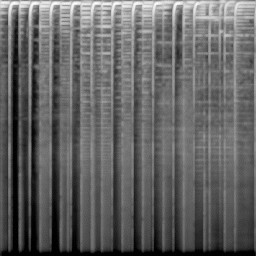

In [11]:
# Faster but noisy
import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid

n_samples_per_class = 1

ddim_steps = 50
ddim_eta = 0.0


all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        
        print(f"rendering {n_samples_per_class} examples in {ddim_steps} steps")

        samples_ddim, _ = sampler.sample(S=ddim_steps,
                                            batch_size=n_samples_per_class,
                                            shape=[1, 256, 256],
                                            verbose=False,
                                            eta=ddim_eta)

        x_samples_ddim = torch.clamp((samples_ddim+1.0)/2.0, 
                                        min=0.0, max=1.0)
        all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

In [37]:
audio = image_to_audio(Image.fromarray(grid.astype(np.uint8)).convert('L'))
audio = loop_it(audio,loops=3)

display(Audio(audio, rate=22050))

In [13]:
def save_audio(audio, filename="test.wav"):
    import soundfile as sf
    audio = (audio-np.min(audio))/(np.max(audio)-np.min(audio))
    sf.write(filename, audio, 22050)

save_audio(audio, filename="test.wav")

In [36]:
grid1 = grid[:,:,:]
a = Image.fromarray(grid.astype(np.uint8))
a = a.resize((128,256))
b = np.concatenate([np.array(a),np.array(a)],1)
# b.shape
# Image.fromarray(b.astype(np.uint8))
audio = image_to_audio(Image.fromarray(b.astype(np.uint8)).convert('L'))
audio = loop_it(audio,loops=3)

display(Audio(audio, rate=22050))

In [ ]:
audio = image_to_audio(Image.fromarray(grid1.astype(np.uint8)).convert('L'))
# audio = loop_it(audio,loops=3)

display(Audio(audio, rate=22050))